<a href="https://colab.research.google.com/github/bubbles42/Fish-Weight-Regression-Model/blob/main/Fish_Weight_Predictions_(Regression_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phase 1) Business Understanding

We are looking at a dataset of different fish types and trying to predict the weight of a fish based on its measurments.

##Imports & Custom Functions

In [44]:
#Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

#Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

#Config
from sklearn import set_config
from IPython.core.display import clear_output

#Warnings
import warnings

In [79]:
#Set filter warnings to ignore
warnings.filterwarnings('ignore')

#Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#SK Learn Display
set_config(display='digram', transform_output='pandas')

In [9]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(pipe, X_train, y_train, X_test, y_test,
                       model_name='Regression Model'):

  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  metrics = ['train_MAE','test_MAE',
             'train_RMSE', 'test_RMSE',
             'train_R2', 'test_R2']

  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  ## Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[model_name])
  scores.loc[model_name, :] = [train_mae, test_mae,
                              train_rmse, test_rmse,
                              train_r2, test_r2]

  return scores

#Phase 2) Data Understanding

We will now get an understanding of what types of data we are working with, as well as see what kind of preprocessing may be needed for our model.

##Load in Data

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo - Data Science & Machine Learning/Machine Learning Fundamentals/Mock Belt Exams/Mock 1/Data/Fish - Fish.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  155 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  157 non-null    float64
 3   Length2  157 non-null    float64
 4   Length3  150 non-null    float64
 5   Height   156 non-null    float64
 6   Width    157 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


##Inspect the Data

In [12]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataframe.')

There are 159 rows and 7 columns in the dataframe.


In [14]:
df.describe(include='number')

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,157.000000,157.000000,150.000000,156.000000,157.000000
mean,398.326415,26.080255,28.168153,31.196000,8.907132,4.416820
std,357.978317,9.939357,10.407117,11.071718,4.250476,1.695044
min,0.000000,7.500000,8.400000,10.800000,1.728400,1.047600
25%,120.000000,19.000000,21.000000,23.275000,5.949000,3.375600
50%,273.000000,25.000000,27.000000,29.700000,7.733000,4.248500
75%,650.000000,32.500000,35.000000,39.575000,12.038100,5.589000
max,1650.000000,59.000000,60.000000,64.000000,18.957000,8.142000


In [15]:
print(f'There are {df.duplicated().sum()} duplicated rows.')

There are 0 duplicated rows.


In [17]:
df['Species'].value_counts()

Perch        53
Bream        33
Roach        19
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Beam          2
Name: Species, dtype: int64

There are some missing values throughout the dataset, however we do not have any duplicated data. Besides the null values we need to address the 2 Beam fish that should be Bream fish. There are no extremely odd values that we should investigate.

##EDA

###Custom EDA Functions

In [33]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='Weight',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='Weight',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

###Categorical EDA

(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'Species vs. Weight'}, xlabel='Species', ylabel='Weight'>)


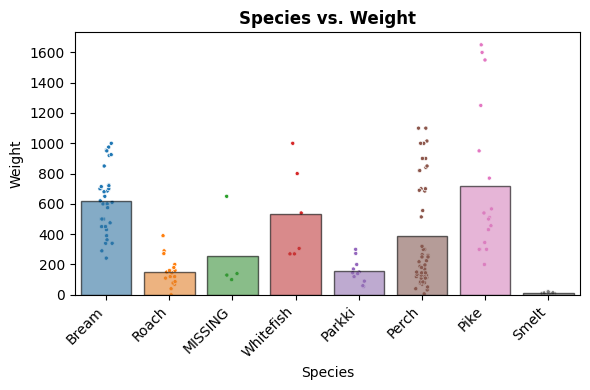

In [38]:
for c in cat_cols:
  print(plot_categorical_vs_target(df, x=c))

It appears that some fish species are inherently larger than others. This could come into play when determining the weight of the fish.

###Correlation

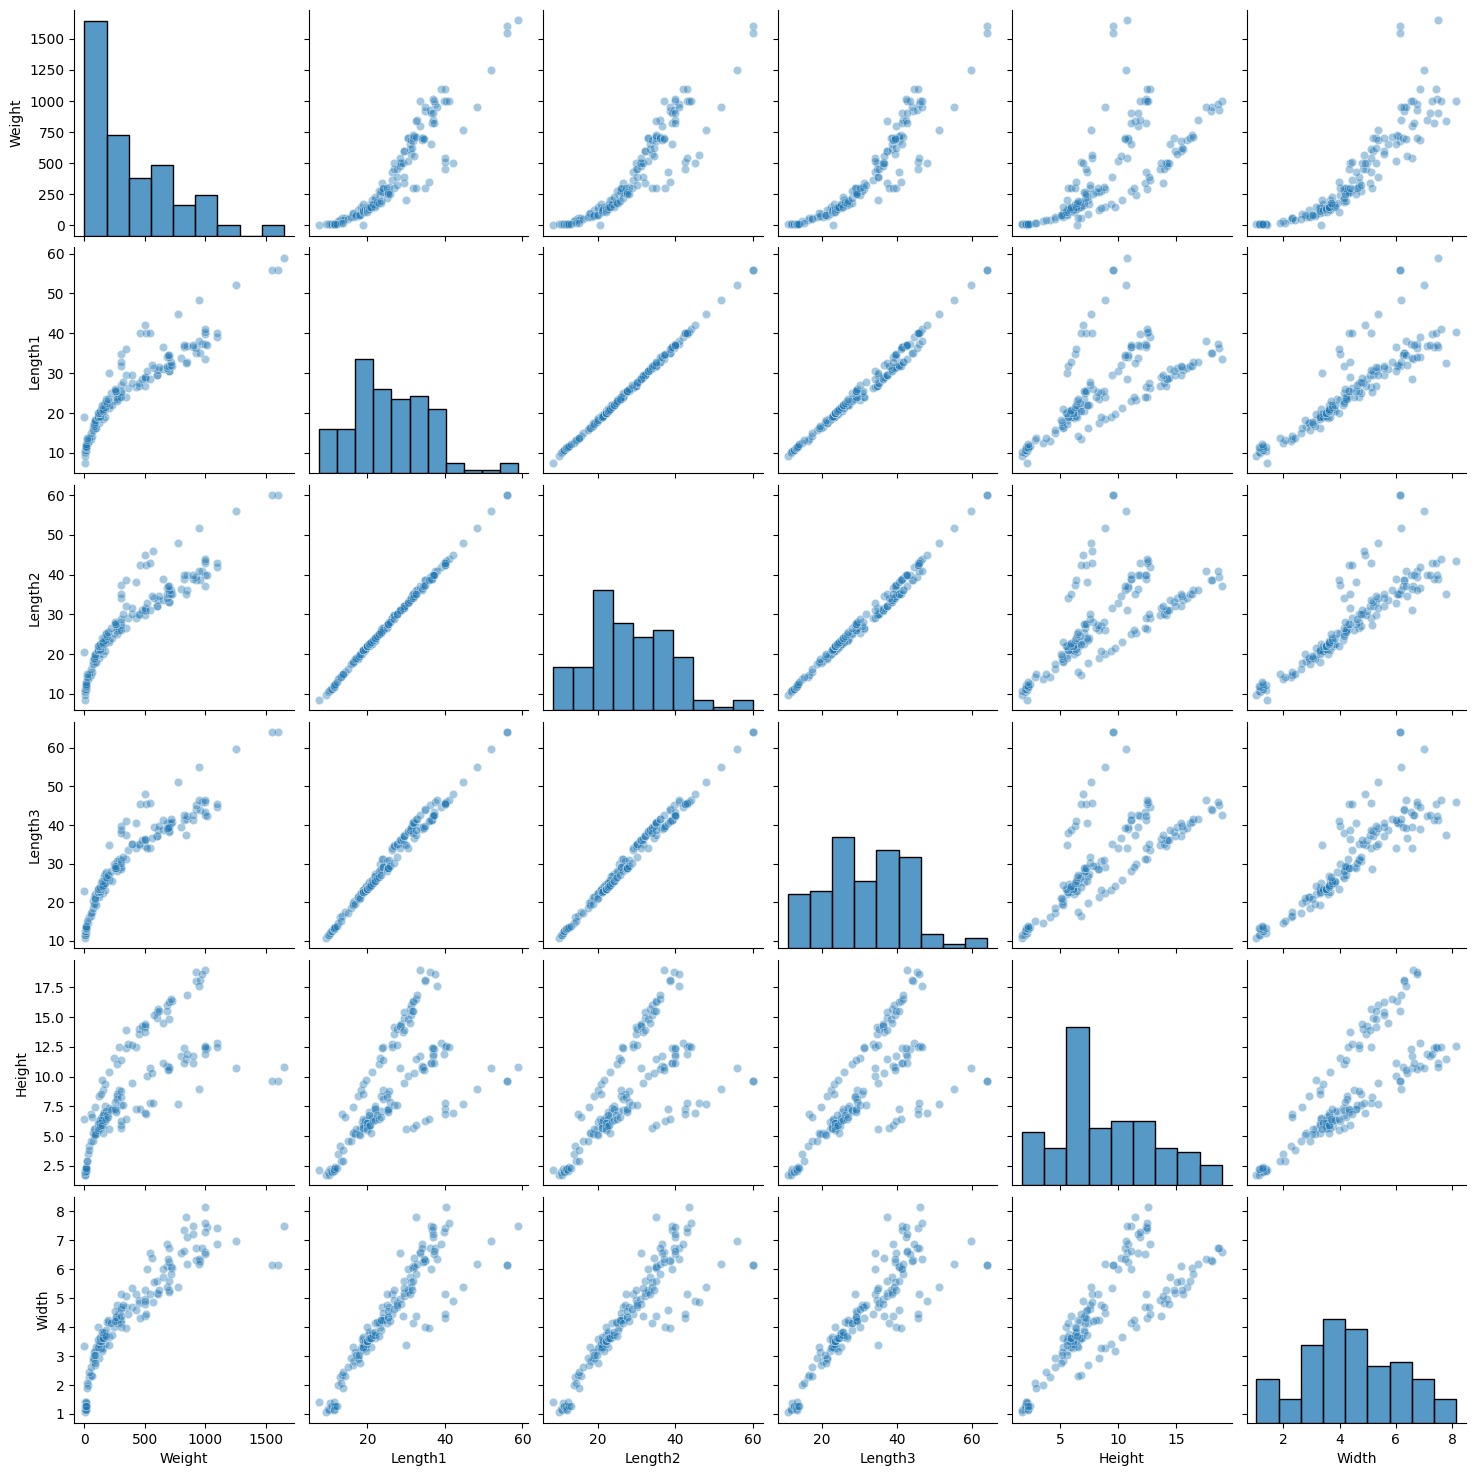

In [40]:
sns.pairplot(df, kind='scatter', plot_kws={'alpha':0.4})

This pairplot helps to visulize the correlation between the features and the target. As we can see all of our numberic features have a farily strong positive correlation with one another.

#Phase 3) Data Preperation

##Fix Species Column

In [19]:
df['Species'] = df['Species'].replace('Beam', 'Bream')
df['Species'].value_counts()

Perch        53
Bream        35
Roach        19
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

##Data Split for Model Validation

In [20]:
from sklearn.utils import random
#Define features and target
target = 'Weight'
X = df.drop(columns=target)
y = df[target]

#Train Test Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Preprocess Data

##ID Feature dtypes

* **Ordinal:**None
* **Numeric:**Length1, Length2, Length3, Height, Width
* **Nominal:**Species

##Pipelines

###Nominal Pipeline

In [24]:
#Create Nominal Column Variable
cat_cols = X_train.select_dtypes('object').columns

#Instantiate the transformers
nom_impute = SimpleImputer(strategy='constant', fill_value='Missing')
ohe_nom = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#Define the nominal pipe and tuple
nom_pipe = make_pipeline(nom_impute, ohe_nom)
nom_tup = ('nominal', nom_pipe, cat_cols)

Here we are going to fill in the missing species with Missing so that we can see that there are some missing species for the dataset that we can possibly get from our SME.

###Numeric Pipeline

In [77]:
num_cols = X_train.select_dtypes('number').columns

num_impute = SimpleImputer(strategy='mean')
num_scale = StandardScaler()

num_pipe = make_pipeline(num_impute, num_scale)

num_tup = ('number', num_pipe, num_cols)

For our numeric columns we will use the average of each columns to full the null values. This will keep out data aligned with the current mean.

##Column Transformer

In [27]:
coltran = ColumnTransformer([nom_tup, num_tup],
                            verbose_feature_names_out=False)

coltran.fit(X_train)

ColumnTransformer(transformers=[('nominal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Species'], dtype='object')),
                                ('number', SimpleImputer(),
                                 Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object'))],
                  verbose_feature_names_out=False)

In [29]:
X_train_pro = coltran.transform(X_train)
X_test_pro = coltran.transform(X_test)

In [30]:
display(X_train_pro.head())

print(f'\nshape of processed data is: {X_train_pro.shape}')

print(f'\nThere are {X_train_pro.isna().sum().sum()} missing values')

print(f'\nThe datatypes are {X_train_pro.dtypes}')

,Species_Bream,Species_Missing,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish,Length1,Length2,Length3,Height,Width
26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,35.0,40.6,8.773795,6.0900
137,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42.0,45.0,48.0,6.960000,4.8960
146,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,10.5,11.6,1.972000,1.1600
90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0,22.0,23.5,5.522500,3.9950
66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19.0,20.7,23.2,8.537600,3.2944



shape of processed data is: (119, 13)

There are 0 missing values

The datatypes are Species_Bream        float64
Species_Missing      float64
Species_Parkki       float64
Species_Perch        float64
Species_Pike         float64
Species_Roach        float64
Species_Smelt        float64
Species_Whitefish    float64
Length1              float64
Length2              float64
Length3              float64
Height               float64
Width                float64
dtype: object


Our preprocessing and transforming have taken, so we will now move into building out our model.

#Phase 4) Modeling the Data

##Baseline Model

In [31]:
dummymod = DummyRegressor(strategy='mean')
dummypipe = make_pipeline(coltran, dummymod)
dummypipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Species'], dtype='object')),
                                                 ('number', SimpleImputer(),
                                                  Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object'))],
                     

In [32]:
scoresdf = evaluate_regression(dummypipe, X_train, y_train, X_test, y_test,
                               model_name='Dummy Model')

scoresdf

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Dummy Model,288.0584,314.7283,355.271,361.6505,0.0,-0.0031


##Random Forest Model

###Baseline RFM

In [46]:
ranfor = RandomForestRegressor(max_depth=None, random_state=42)

ranfor_pipe = make_pipeline(coltran, ranfor)
ranfor_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Species'], dtype='object')),
                                                 ('number', SimpleImputer(),
                                                  Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object'))],
                     

In [47]:
ranbase_metrics = evaluate_regression(ranfor_pipe, X_train, y_train, X_test, y_test,
                                      model_name='Base Random Forest')

#scoresdf = pd.concat([scoresdf, ranbase_metrics])
scoresdf

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Dummy Model,288.0584,314.7283,355.271,361.6505,0.0,-0.0031
Base Random Forest,17.1441,42.6149,33.4358,64.9721,0.9911,0.9676


We can see that just using the base Random Forest Model has provided a significant imporvment and it is performing well on the training and testing data.

###Hypertune RFM

In [48]:
ranfor_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('nominal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Species'], dtype='object')),
                                   ('number', SimpleImputer(),
                                    Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object'))],
                     verbose_feature_names_out=False)),
  ('randomforestregressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'co

In [52]:
ranparams = {
 'randomforestregressor__max_depth': [None, 1, 5, 10, 15, 20],
 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', None],
 'randomforestregressor__min_samples_leaf': [1, 2, 3, 5, 10],
 'randomforestregressor__n_estimators': [10, 20, 50, 100, 200],
}

In [53]:
rangs = GridSearchCV(ranfor_pipe, ranparams, n_jobs=-1, verbose=1)
rangs.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('nominal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Species'], dtype='object')),
                    

In [71]:
rangs.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__n_estimators': 50}

In [74]:
#Set a variable to the best estimator to evaluate it
best_ranfor = rangs.best_estimator_

tuned_ranfor = evaluate_regression(best_ranfor, X_train, y_train, X_test, y_test,
                    model_name='Tuned Random Forest')
tuned_ranfor

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Tuned Random Forest,17.7387,41.3521,36.4985,62.6869,0.9894,0.9699


Tuning the model seems to have slightly improved the performance. If we look at the R2 score for the train data we can see it decreases slightly and the test data has a slight incresase. This shows that the model is better to explain the errors on new data after being tuned.

In [75]:
scoresdf = pd.concat([scoresdf, tuned_ranfor])
scoresdf

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Dummy Model,288.0584,314.7283,355.271,361.6505,0.0,-0.0031
Base Random Forest,17.1441,42.6149,33.4358,64.9721,0.9911,0.9676
Tuned Random Forest,17.7387,41.3521,36.4985,62.6869,0.9894,0.9699


##Decision Tree Model

###Baseline DTM

In [80]:
dectree = DecisionTreeRegressor(max_depth=None, random_state=42)
dectree_pipe = make_pipeline(coltran, dectree)

dectree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Species'], dtype='object')),
                                                 ('number', SimpleImputer(),
                                                  Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object'))],
                     

In [90]:
bastdtm = evaluate_regression(dectree_pipe, X_train, y_train, X_test, y_test,
                              model_name='Base Dec Tree')

scoresdf = pd.concat([scoresdf, bastdtm])
scoresdf

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Dummy Model,288.0584,314.7283,355.271,361.6505,0.0,-0.0031
Base Random Forest,17.1441,42.6149,33.4358,64.9721,0.9911,0.9676
Tuned Random Forest,17.7387,41.3521,36.4985,62.6869,0.9894,0.9699
Base Dec Tree,0.4202,57.8325,3.241,88.1424,0.9999,0.9404


The baseline Decision Tree Model seems to have slightly over fit compared to the Random Forest. Let us fine tune this model to see if we can get a better performance.

###Fineuned DTM

In [91]:
max_depth  = dectree_pipe['decisiontreeregressor'].get_depth()
max_depth

11

In [93]:
dectree_pipe.get_params()



{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('nominal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Species'], dtype='object')),
                                   ('number', SimpleImputer(),
                                    Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object'))],
                     verbose_feature_names_out=False)),
  ('decisiontreeregressor', DecisionTreeRegressor(random_state=42))],
 'verbose': False,
 'co

In [94]:
paramsdec = {
 'decisiontreeregressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
 'decisiontreeregressor__max_depth': range(1, max_depth+1),
 'decisiontreeregressor__max_features': [None, 'auto', 'sqrt', 'log2'],
 'decisiontreeregressor__min_samples_leaf': [1, 2, 4, 10, 20, 40, 80, 160, 250],
 'decisiontreeregressor__splitter': ['best', 'random']
}

In [95]:
decgs = GridSearchCV(dectree_pipe, paramsdec, n_jobs=-1, verbose=1)
decgs.fit(X_train, y_train)

Fitting 5 folds for each of 3168 candidates, totalling 15840 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('nominal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Species'], dtype='object')),
                    

In [99]:
decgs.best_params_

{'decisiontreeregressor__criterion': 'poisson',
 'decisiontreeregressor__max_depth': 10,
 'decisiontreeregressor__max_features': None,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__splitter': 'best'}

In [100]:
bestdt = decgs.best_estimator_

tuneddt = evaluate_regression(bestdt, X_train, y_train, X_test, y_test,
                             model_name='Best Decision Tree')

tuneddt

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Best Decision Tree,1.4902,45.9242,6.3713,75.8839,0.9997,0.9558


#Phase 5) Evaluation

In [101]:
scoresdf = pd.concat([scoresdf, tuneddt])
scoresdf

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Dummy Model,288.0584,314.7283,355.271,361.6505,0.0,-0.0031
Base Random Forest,17.1441,42.6149,33.4358,64.9721,0.9911,0.9676
Tuned Random Forest,17.7387,41.3521,36.4985,62.6869,0.9894,0.9699
Base Dec Tree,0.4202,57.8325,3.241,88.1424,0.9999,0.9404
Best Decision Tree,1.4902,45.9242,6.3713,75.8839,0.9997,0.9558


Based on the models we built for this dataset, I would reccommend using the Tuned Random Forest Model as it had the best performance on the testing data and the best R2 scores on the testing data. This model should perform well on unknown/unseen data.